In [2]:
import numpy as np
import os
from matplotlib import pyplot as plt
%matplotlib inline
from astropy.table import Table

from astropy.wcs import WCS
from astropy.io import fits
from astropy.io import ascii

from IPython.display import Image
import corner

In [6]:
tabledir = '/Users/k215c316/Virgo/v0-03Jul2020/'
mgstab = Table.read(tabledir+'vf_north_v0_z0mgs.fits')
hyptab = Table.read(tabledir+'vf_north_v0_hyperleda.fits')

Text(0.5, 1.0, 'SFR v. Mstar')

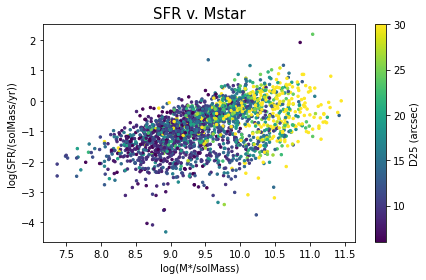

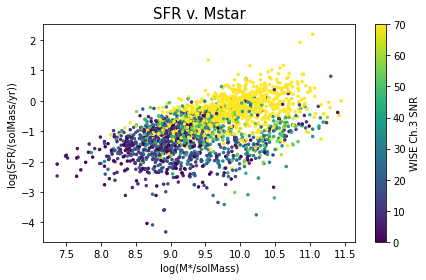

In [7]:
Mstar = mgstab['logmass']  #x axis
SFR = mgstab['logsfr']   #y axis; frequently deriven from WISE C4 data
D25 = 10**(hyptab['logd25'])

plt.figure(figsize=(7,4))
plt.scatter(Mstar,SFR,c=D25,vmin=6,vmax=30,s=6)
cb = plt.colorbar()
cb.set_label('D25 (arcsec)')
plt.xlabel('log(M*/solMass)')
plt.ylabel('log(SFR/(solMass/yr))')
plt.title('SFR v. Mstar', fontsize=15)

snr = mgstab['flux_wise3']/mgstab['std_flux_wise3']

plt.figure(figsize=(7,4))
plt.scatter(Mstar,SFR,c=snr,vmin=0,vmax=70,s=6)
cb2 = plt.colorbar()
cb2.set_label('WISE Ch.3 SNR')
plt.xlabel('log(M*/solMass)')
plt.ylabel('log(SFR/(solMass/yr))')
plt.title('SFR v. Mstar', fontsize=15)

In [13]:
#ADAP proposal uses an SNR cut of > 20. 

In [61]:
snr_flag = (snr>20)                            #1559 galaxies satisfy this condition, notwithstanding
                                               #those with blank entries

D25_flag = (D25>30)
gal_flag = snr_flag & D25_flag

In [62]:
len(mgstab[gal_flag])

232

In [24]:
#though this sample is twice the number of the first, the galaxies here are nevertheless well-constrained
#in that the largest n' most luminous galaxies are favored

In [63]:
new_sample = mgstab[gal_flag]

Text(0.5, 1.0, 'SFR v. Mstar')

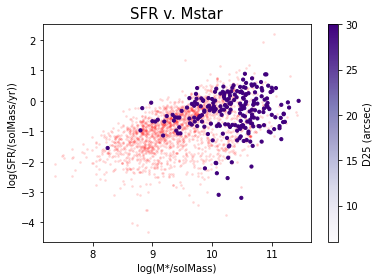

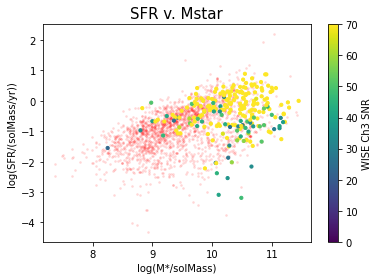

In [74]:
plt.figure()
plt.scatter(Mstar,SFR,s=3,alpha=0.1,color='red')

Mstar_cut = mgstab['logmass'][gal_flag]
SFR_cut = mgstab['logsfr'][gal_flag]
D25_cut = 10**(hyptab['logd25'][gal_flag])

plt.scatter(Mstar_cut,SFR_cut,c=D25_cut,vmin=6,vmax=30,s=10,alpha=5,cmap='Purples')
cb = plt.colorbar()
cb.set_label('D25 (arcsec)')

plt.xlabel('log(M*/solMass)')
plt.ylabel('log(SFR/(solMass/yr))')
plt.title('SFR v. Mstar', fontsize=15)

plt.figure()
plt.scatter(Mstar,SFR,color='red',s=3,alpha=0.1)

plt.scatter(Mstar_cut,SFR_cut,c=snr[gal_flag],vmin=0,vmax=70,s=10,alpha=5,cmap='viridis')
cb = plt.colorbar()
cb.set_label('WISE Ch3 SNR')

plt.xlabel('log(M*/solMass)')
plt.ylabel('log(SFR/(solMass/yr))')
plt.title('SFR v. Mstar', fontsize=15)

In [75]:
maintab = Table.read(tabledir+'vf_north_v0_main.fits')
main = maintab[gal_flag]
main.write('sample_main_two.fits')

--------------------------------------------------------------

In [83]:
#now to run GALFIT on this new sample.

def readfile(filename):
    
    fileobj=open(filename,'r')                               #opens the file, of course
    words=fileobj.read().splitlines()                        #splits the header and data into two lists
    header = words[0].split()                                #splits header, data arrays into elements
    data = words[1].split()
    fileobj.close()
    return header,data


def readfile2(filename):                                     
    fileobj=open(filename,'r')
    words=fileobj.read().splitlines()
    header = words[0].split()
    fileobj.close()
    return header


def run_galfit_all(galaxy_sample):
    
    os.chdir(homedir+'/github/WISE_test_two')
    %run ~/github/virgowise/wisesize.py
    
    
    
    for n in range(0,len(galaxy_sample)):
        
        try:
            g = galaxy(galaxy_sample['RA'][n], galaxy_sample['DEC'][n],
                      galaxy_sample['radius'][n], name = galaxy_sample['prefix'][n], band='3')
            print(galaxy_sample['prefix'][n])
            g.run_simple(convflag=False)
            
            t = homedir+'/github/WISE_test_two/'+galaxy_sample[n]['prefix']+'-unwise-w3-log.txt'
            header,data = readfile(t)
            header.pop(0)                                    #removes the pound_sign from the array
            header.append('prefix')
            header.append('success_flag')
            
            for i in range(0,len(data)):
                data[i] = float(data[i])
            data.append(galaxy_sample[n]['prefix'])
            data.append(1)                                   #success_flag value of one
            
            if n == 0:                                       #if the galaxy is the first entry, then
                file_test = [header,data]                    #append to the list both the header & data lists
                file_plots = [header,data]                   #append to list for corner plots
                
            else:
                file_test2 = [header,data]                   #otherwise, only include the data list
                file_test.append(file_test2[1])
                file_plots.append(file_test2[1])
                    
        except:
            
            t = homedir+'/github/WISE_test_two/'+galaxy_sample[n]['prefix']+'-unwise-w3-log.txt'
            header = readfile2(t)
            header.pop(0)                                    #removes the pound_sign from the array
            header.append('prefix')
            header.append('success_flag')
            
            data = []
            for num in range(0,len(header)-2):
                data.append(-999)
            data.append(galaxy_sample[n]['prefix'])
            data.append(0)                                   #success_flag value of zero
               
            file_test2 = [header,data]
            file_test.append(file_test2[1])

            
            print(galaxy_sample['prefix'][n], ' ' , 'was unsuccessful.')
            continue
        
    data_array = np.array(file_test)
    data_array_plots = np.array(file_plots)
    np.savetxt("sample2.txt",data_array,fmt="%s")                    #all
    np.savetxt("sample2_cornerplots.txt",data_array_plots,fmt="%s")        #for corner plots

In [4]:
homedir = os.getenv('HOME')
vfmain = Table.read(homedir+'/github/research/sample_main_two.fits')

In [ ]:
run_galfit_all(vfmain)

In [92]:
#generating corner plots

In [96]:
tab = ascii.read(homedir+"/github/WISE_test_two/sample2_cornerplots.txt")

In [97]:
data = np.array([tab['nsersic'],tab['re'],tab['mag']])

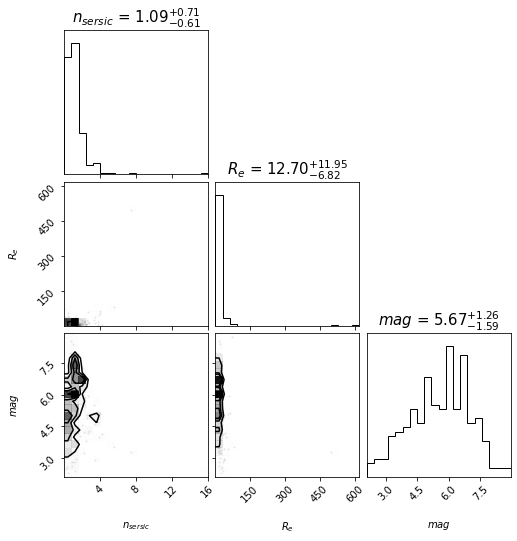

In [99]:
figure = corner.corner(data.T,labels=[r'$n_{sersic}$',r'$R_e$',r'$mag$'],show_titles=True,
                      title_kwargs={"fontsize":15})

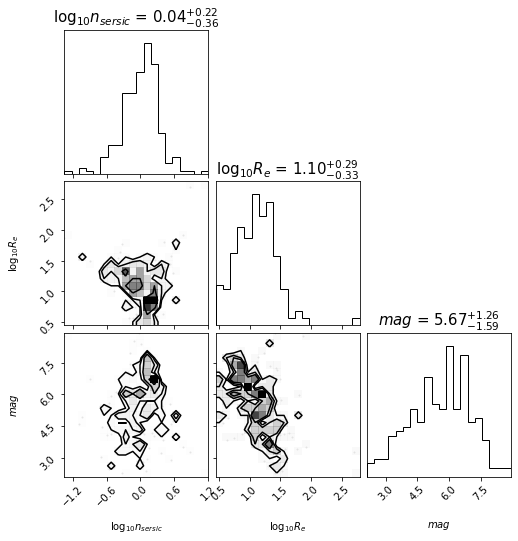

In [104]:
data_log = np.array([np.log10(tab['nsersic']),np.log10(tab['re']),tab['mag']])
figure = corner.corner(data_log.T,labels=[r'$\log_{10}{n_{sersic}}$', r'$\log_{10}{R_e}$', r'$mag$'],
                       show_titles=True, title_kwargs={"fontsize":15})

In [5]:
tab = ascii.read(homedir+"/github/WISE_test_two/sample2_cornerplots.txt")